Check the specifications of the current runtime in Colab

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil

import os
import psutil
import humanize
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 158.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


Download the lung/CT segmentation dataset directly from Kaggle

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

from google.colab import files
files.upload() # upload your Kaggle.json API token, more information: https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab

In [0]:
!cp kaggle.json ~/.kaggle/ # place the kaggle.json file into the .kaggle/ folder

In [0]:
!kaggle datasets download -d kmader/finding-lungs-in-ct-data # download and unzip the dataset
!unzip /content/finding-lungs-in-ct-data.zip

**Import the relevant libraries**

In [5]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow import keras

TensorFlow 2.x selected.


In [0]:
import numpy as np 
import pandas as pd 
from glob import glob
import nibabel as nib
from warnings import warn
from skimage.util import montage
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Helper Functions
def montage_nd(in_img):
    if len(in_img.shape)>3:
        return montage(np.stack([montage_nd(x_slice) for x_slice in in_img],0))
    elif len(in_img.shape)==3:
        return montage(in_img)
    else:
        warn('Input less than 3d image, returning original', RuntimeWarning)
        return in_img

def read_all_slices(in_paths, DS_FACT = 8, rescale = True):
    '''
    DS_FACT: downscaling
    '''
    cur_vol = np.expand_dims(np.concatenate([nib.load(c_path).get_fdata()[:, ::DS_FACT, ::DS_FACT] 
                                          for c_path in in_paths], 0), -1)
    if rescale:
        return (cur_vol.astype(np.float32) + 500)/2000.0
    else:
        return cur_vol/255.0 # normalize the volume

def read_both(in_paths):
    in_vol = read_all_slices(in_paths)
    in_mask = read_all_slices(map(lambda x: x.replace('IMG_', 'MASK_'), in_paths), rescale = False)
    return in_vol, in_mask

def gen_chunk(in_img, in_mask, slice_count = 10, batch_size = 16):
    while True:
        img_batch = []
        mask_batch = []
        for _ in range(batch_size):
            s_idx = np.random.choice(range(in_img.shape[0]-slice_count))
            img_batch += [in_img[s_idx:(s_idx+slice_count)]]
            mask_batch += [in_mask[s_idx:(s_idx+slice_count)]]
        yield np.stack(img_batch, 0), np.stack(mask_batch, 0)

def gen_aug_chunk(in_gen):
    for i, (x_img, y_img) in enumerate(in_gen):
        xy_block = np.concatenate([x_img, y_img], 1).swapaxes(1, 4)[:, 0]
        img_gen = d_gen.flow(xy_block, shuffle=True, seed=i, batch_size = x_img.shape[0])
        xy_scat = next(img_gen)
        # unblock
        xy_scat = np.expand_dims(xy_scat,1).swapaxes(1, 4)
        yield xy_scat[:, :xy_scat.shape[1]//2], xy_scat[:, xy_scat.shape[1]//2:]

In [8]:
# visualise some data
all_images=glob(os.path.join('3d_images','IMG_*'))
print(len(all_images),' matching files found:',all_images[0])
train_paths, test_paths = train_test_split(all_images, random_state = 2020, test_size = 0.5)
print(len(train_paths), 'training size')
print(len(test_paths), 'testing size')

4  matching files found: 3d_images/IMG_0078.nii.gz
2 training size
2 testing size


train (442, 64, 64, 1) mask (442, 64, 64, 1)
test (766, 64, 64, 1) mask (766, 64, 64, 1)


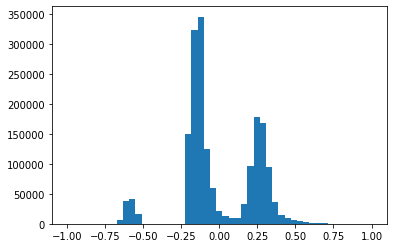

In [9]:
train_vol, train_mask = read_both(train_paths)
test_vol, test_mask = read_both(test_paths)
print('train', train_vol.shape, 'mask', train_mask.shape)
print('test', test_vol.shape, 'mask', test_mask.shape)
plt.hist(train_vol.ravel(), np.linspace(-1, 1, 50));

(16, 10, 64, 64, 1) (16, 10, 64, 64, 1)


(-0.5, 1023.5, 1023.5, -0.5)

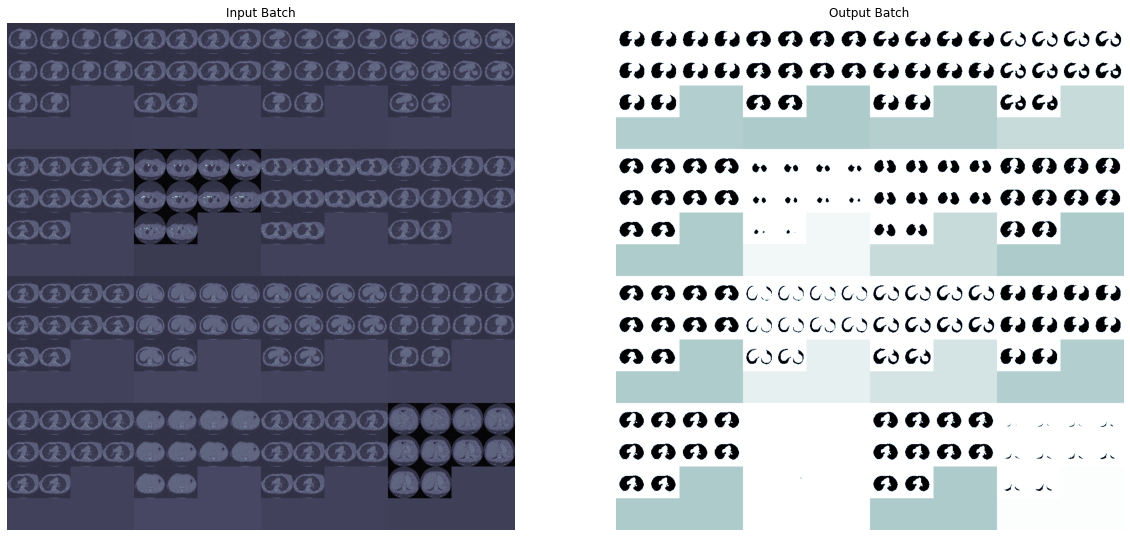

In [10]:
# for training we use larger batch sizes with fewer slices
train_gen = gen_chunk(train_vol, train_mask)
# for validation we use smaller batches with more slices
valid_gen = gen_chunk(test_vol, test_mask, slice_count = 100, batch_size = 1)
x_out, y_out = next(train_gen)
print(x_out.shape, y_out.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_nd(x_out[...,0]), cmap = 'bone')
ax1.set_title('Input Batch')
ax1.axis('off')
ax2.imshow(montage_nd(y_out[...,0]), cmap='bone_r')
ax2.set_title('Output Batch')
ax2.axis('off')

In [51]:
# construct the 3D UNet Model
def unet3d():
    in_layer = tf.keras.layers.Input((None, None, None, 1))
    bn = tf.keras.layers.BatchNormalization()(in_layer)
    cn1 = tf.keras.layers.Conv3D(8, 
                kernel_size = (1, 5, 5), 
                padding = 'same',
                activation = 'relu')(bn)
    cn2 = tf.keras.layers.Conv3D(8, 
                kernel_size = (3, 3, 3),
                padding = 'same',
                activation = 'linear')(cn1)
    bn2 = tf.keras.layers.BatchNormalization()(cn2)      
    bn2 = tf.keras.layers.Activation('relu')(bn2)

    dn1 = tf.keras.layers.MaxPooling3D((2, 2, 2))(bn2)
    cn3 = tf.keras.layers.Conv3D(16, 
                kernel_size = (3, 3, 3),
                padding = 'same',
                activation = 'linear')(dn1)
    bn3 = tf.keras.layers.BatchNormalization()(cn3)
    bn3 = tf.keras.layers.Activation('relu')(bn3)

    dn2 = tf.keras.layers.MaxPooling3D((1, 2, 2))(bn3)
    cn4 = tf.keras.layers.Conv3D(32, 
                kernel_size = (3, 3, 3),
                padding = 'same',
                activation = 'linear')(dn2)
    bn4 = tf.keras.layers.BatchNormalization()(cn4)
    bn4 = tf.keras.layers.Activation('relu')(bn4)

    up1 = tf.keras.layers.Conv3DTranspose(16, 
                        kernel_size = (3, 3, 3),
                        strides = (1, 2, 2),
                        padding = 'same')(bn4)

    cat1 = tf.keras.layers.concatenate([up1, bn3])

    up2 = tf.keras.layers.Conv3DTranspose(8, 
                        kernel_size = (3, 3, 3),
                        strides = (2, 2, 2),
                        padding = 'same')(cat1)

    pre_out = tf.keras.layers.concatenate([up2, bn2])

    pre_out = tf.keras.layers.Conv3D(1, 
                kernel_size = (1, 1, 1), 
                padding = 'same',
                activation = 'sigmoid')(pre_out)

    pre_out = tf.keras.layers.Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
    out = tf.keras.layers.ZeroPadding3D((1, 2, 2))(pre_out)
    
    model = tf.keras.models.Model(inputs = [in_layer], outputs = [out])
    model.summary()
    
    return model

sim_model = unet3d()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, None, None, N 4           input_5[0][0]                    
__________________________________________________________________________________________________
conv3d_18 (Conv3D)              (None, None, None, N 208         batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv3d_19 (Conv3D)              (None, None, None, N 1736        conv3d_18[0][0]                  
____________________________________________________________________________________________

In [25]:
sim_model.predict(x_out).shape # ensure the model works and the result has the right size

(16, 10, 64, 64, 1)

In [0]:
sim_model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics = ['binary_accuracy', 'mse']) # monitor accuracy and mean squared error during training

weight_path="{}_best_weights.hdf5".format('convlstm_model')

checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5,
                                                      verbose=1, mode='auto', min_delta=0.0001,
                                                      cooldown=5, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                      mode="min", patience=20)
callbacks_list = [checkpoint, early_stopping, reduceLROnPlat]

In [14]:
d_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15, 
                           width_shift_range=0.15, 
                           height_shift_range=0.15, 
                           shear_range=0.1, 
                           zoom_range=0.25, 
                           fill_mode='nearest',
                           horizontal_flip=False, 
                           vertical_flip=False)


train_aug_gen = gen_aug_chunk(train_gen)
x_out, y_out = next(train_aug_gen)
print(x_out.shape, y_out.shape)

(16, 10, 64, 64, 1) (16, 10, 64, 64, 1)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 64, 64, 20) (20 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [27]:
sim_model.fit_generator(train_aug_gen, 
                        epochs=50,
                        steps_per_epoch = 100, 
                        validation_data = valid_gen, 
                        validation_steps=10,
                       callbacks = callbacks_list)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 64, 64, 20) (20 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5334 - binary_accuracy: 0.9052 - mse: 0.0517
Epoch 00001: val_loss improved from inf to 0.34754, saving model to convlstm_model_weights.best.hdf5
100/100 [==============================] - 12s 120ms/step - loss: 0.5334 - binary_accuracy: 0.9052 - mse: 0.0517 - val_loss: 0.3475 - val_binary_accuracy: 0.9020 - val_mse: 0.0790 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.4620 - binary_accuracy: 0.9318 - mse: 0.0309
Epoch 00002: val_loss improved from 0.34754 to 0.22024, saving model to convlstm_model_weights.best.hdf5
100/100 [==============================] - 12s 117ms/step - loss: 0.4620 - binary_accuracy: 0.9318 - mse: 0.0309 - val_loss: 0.2202 - val_binary_accuracy: 0.9462 - val_mse: 0.0446 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4446 - binary_accuracy: 0.9345 - mse: 0.0289
Epoch 00003: val_loss improved from 0.22024 to 0.10029, s

In [0]:
sim_model.load_weights(weight_path)

In [0]:
test_single_vol, test_single_mask = read_both(test_paths[1:2])
test_single_vol = test_single_vol[1:]
test_single_mask = test_single_mask[1:]

In [0]:
pred_seg = sim_model.predict(np.expand_dims(test_single_vol,0))[0]

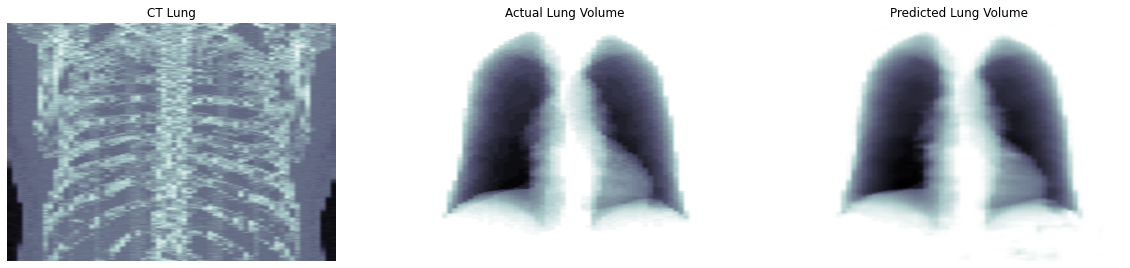

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
ax1.imshow(np.max(test_single_vol[::-1, :, :, 0], 1), cmap = 'bone')
ax1.set_aspect(0.1)
ax1.set_title('CT Lung')
ax1.axis('off')
ax2.imshow(np.sum(test_single_mask[::-1, :, :, 0], 1), cmap = 'bone_r')
ax2.set_title('Actual Lung Volume')
ax2.set_aspect(0.1)
ax2.axis('off')
ax3.imshow(np.sum(pred_seg[::-1, :, :, 0], 1), cmap = 'bone_r')
ax3.set_title('Predicted Lung Volume')
ax3.set_aspect(0.1)
ax3.axis('off')
# plt.tight_layout()
fig.savefig('full_scan_prediction.png', dpi = 300)

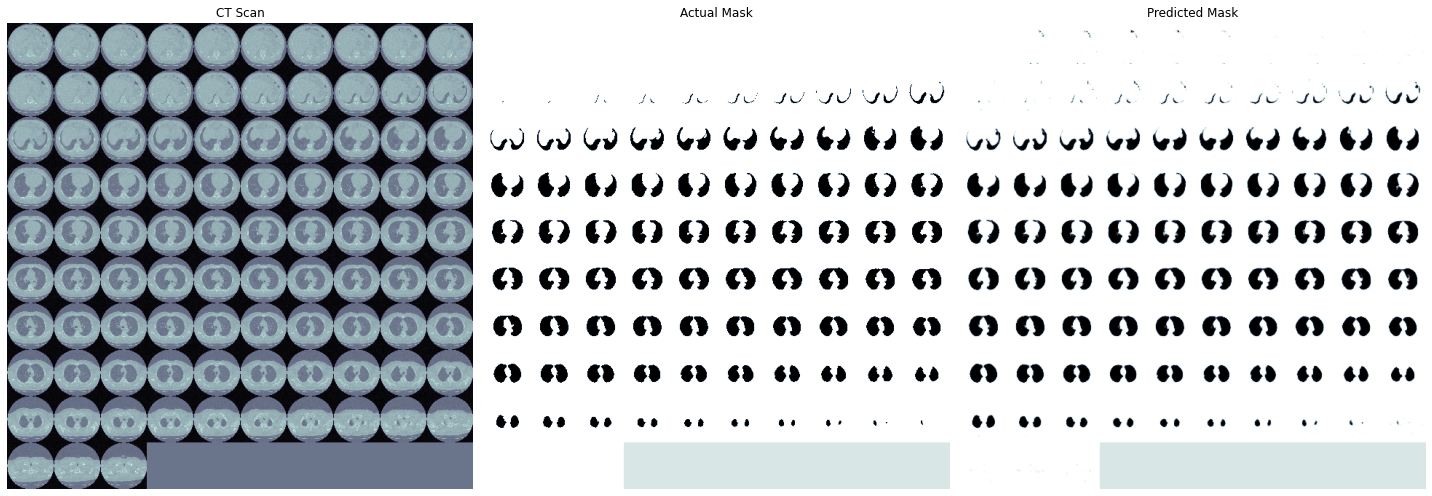

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
ax1.imshow(montage(test_single_vol[::5, :, :, 0]), cmap = 'bone')
ax1.set_title('CT Scan')
ax1.axis('off')
ax2.imshow(montage(test_single_mask[::5, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Actual Mask')
ax2.axis('off')
ax3.imshow(montage(pred_seg[::5, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Predicted Mask')
ax3.axis('off')
plt.tight_layout()
fig.savefig('subsample_pred.png', dpi = 300)

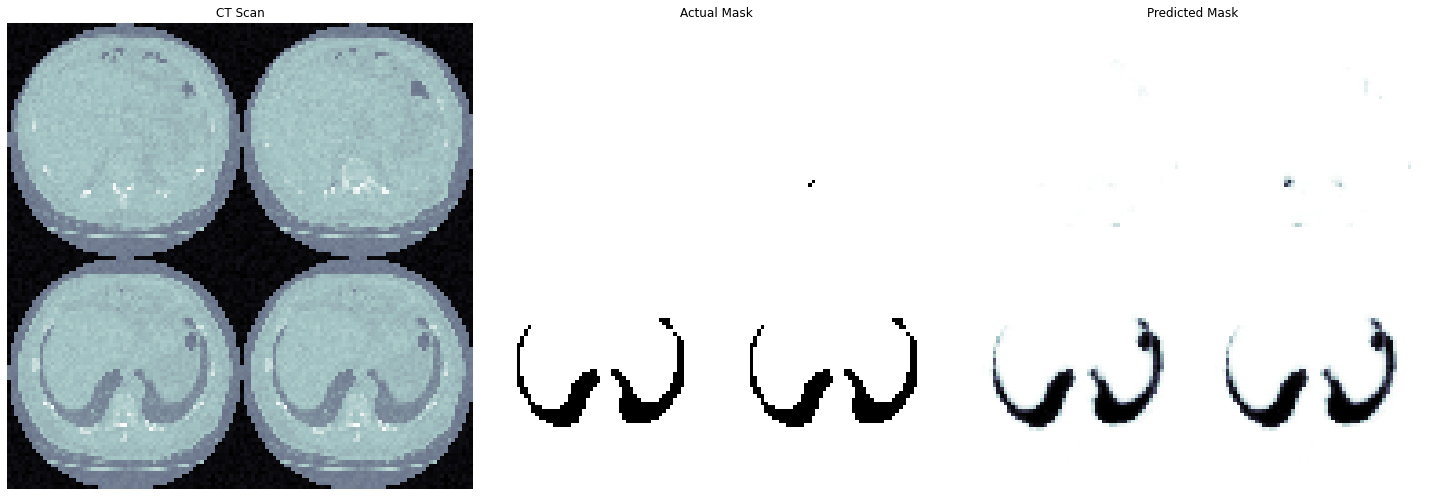

In [49]:
# visualize predictions in the bowel
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
bow_lung_idx = np.array([30, 50]+[100, 100])
ax1.imshow(montage(test_single_vol[bow_lung_idx, :, :, 0]), cmap = 'bone')
ax1.set_title('CT Scan')
ax1.axis('off')
ax2.imshow(montage(test_single_mask[bow_lung_idx, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Actual Mask')
ax2.axis('off')
ax3.imshow(montage(pred_seg[bow_lung_idx, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Predicted Mask')
ax3.axis('off')
plt.tight_layout()
fig.savefig('bowel_vs_lung.png', dpi = 200)